## What is transfer learning?

Transfer learning is machine learning approach where model trained on one task or dataset and applying to another dataset (our own)
to improve the performance.

- Pretrained Model = Foundation Models

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchmetrics import Accuracy

try:
    from torchinfo import summary
except:
    print(f"[INFO] Couldn't find the torchinfo...\n Installing it.....")
    !pip install -qq torchinfo
    from torchinfo import summary

# Try to import going_moduler directory. download it from GitHub, if it doesn't work
try:
    from going_modular import data_setup, engine, utils
except:
    print(f"[INFO] Couldn't find the directory...\n Downloading it from github.....")
    !git clone https://github.com/Niloy009/learning_pytorch.git
    !mv leaning_pytorch/going_modular
    !rm -rf learning_pytorch
    from going_modular import data_setup, engine, utils
    


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food101 dataset

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download.")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)
  
  # unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)
  
  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists, skipping re-download.


In [4]:
# Setup directory
train_dir = image_path / 'train'
test_dir = image_path / 'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders
Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use data_setup.py and the create_dataloaders() function we made in 05. PyTorch Going Modular.

There's one thing we have to think about when loading: how to **transform** it?

And with torchvision 0.13+ there's two ways to do this:

1. Manually created transforms - you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

**Important point:** when using a pretrained model, it's important that the data (including your custom data) that you pass through it is transformed in the same way that the data the model was trained on.

In [5]:
# Manual transform

manual_transform = transforms.Compose([transforms.Resize(size=(224,224)), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                            std=[0.229, 0.224, 0.225])
                                        ])


In [6]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, 
                                                                               test_dir=test_dir, 
                                                                               transform=manual_transform, 
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f695d971700>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model
There are various places to get a pretrained model, such as:

1. PyTorch domain libraries
2. Libraries like timm (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1 Which pretrained model should you use?
**Experiment, experiment, experiment!**

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:

1. Speed - how fast does it need to run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images? for FoodVision Mini)?

Where does the model live?

Is it on device? (like a self-driving car)

Or does it live on a server?

Looking at https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

Which model should we chose?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms performance vs size.

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could - http://www.incompleteideas.net/IncIdeas/BitterLesson.html

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT #"DEFAULT" = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
# Get the transforms used to create our pretrained model
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, 
                                                                               test_dir=test_dir, 
                                                                               transform=auto_transforms, 
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f695d887f20>,
 ['pizza', 'steak', 'sushi'])

In [10]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Get the summary of the model with torchinfo

In [11]:
from torchinfo import summary

summary(model=model, 
        input_size=[1,3,224,224], 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [12]:
# Freeze all of the base layers in EffNetB0

for param in model.features.parameters():
    param.requires_grad = False

In [13]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [14]:
# Update the classifier head of our model to suit our problem and send the model to device
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [15]:
summary(model=model, 
        input_size=[1,3,224,224], 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width=18, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]   [1, 3]             --                 Partial
├─Sequential (features)                                      [1, 3, 224, 224]   [1, 1280, 7, 7]    --                 False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]   [1, 32, 112, 112]  --                 False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]   [1, 32, 112, 112]  (864)              False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]  [1, 32, 112, 112]  (64)               False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]  [1, 32, 112, 112]  --                 --
│    └─Sequential (1)                                        [1, 32, 112, 112]  [1, 16, 112, 112]  --                 False
│    

In [16]:
# Define loss function, optimizer and the accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
accuracy = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

In [17]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()


model_results = engine.train(model=model, 
                             train_dataloader=train_dataloader, 
                             test_dataloader=test_dataloader, 
                             loss_fn=loss_fn, 
                             optimizer=optimizer, 
                             accuracy=accuracy, epochs=5, device=device)


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss:  1.0948 | train_accuracy:  0.3984 | test_loss:  0.9034 | test_accuracy:  0.6411
Epoch: 2 | train_loss:  0.8732 | train_accuracy:  0.7500 | test_loss:  0.7873 | test_accuracy:  0.8456
Epoch: 3 | train_loss:  0.7634 | train_accuracy:  0.8242 | test_loss:  0.7454 | test_accuracy:  0.8456
Epoch: 4 | train_loss:  0.7162 | train_accuracy:  0.7500 | test_loss:  0.6350 | test_accuracy:  0.8655
Epoch: 5 | train_loss:  0.6226 | train_accuracy:  0.7930 | test_loss:  0.6234 | test_accuracy:  0.8864
[INFO] Total training time: 12.947 seconds


In [18]:
# Plots the loss curves
model_results

{'train_loss': [1.09475726634264,
  0.8732264488935471,
  0.7633729577064514,
  0.7162355408072472,
  0.6225565634667873],
 'train_accuracy': [0.3984375, 0.75, 0.82421875, 0.75, 0.79296875],
 'test_loss': [0.90340522925059,
  0.7872956593831381,
  0.7453861633936564,
  0.635019322236379,
  0.6234336495399475],
 'test_accuracy': [0.6410984893639883,
  0.845643937587738,
  0.845643937587738,
  0.8655303120613098,
  0.8863636453946432]}

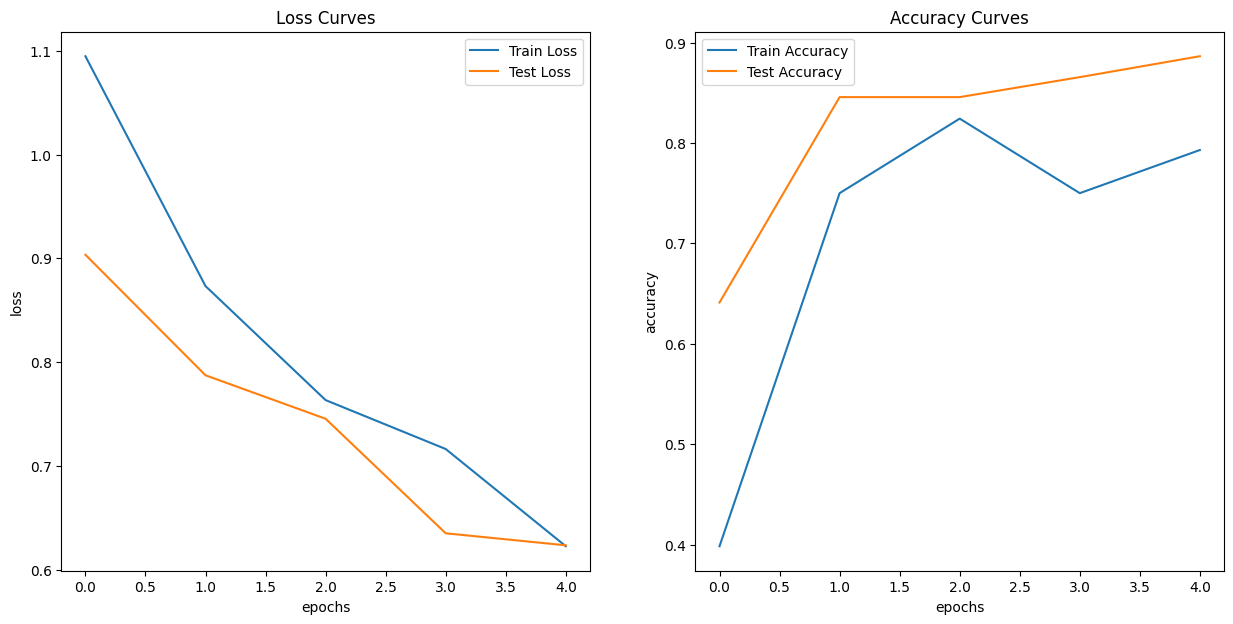

In [19]:
utils.plot_loss_curves(results=model_results)

## 6. Make Predictions on images from the test set

We've a motto to the data explorer call *visualize, visualize, visualize*!

And make some qualitiative predictions on our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same Shape - images need to be same shape as model was trained on
* Same Datatype - custom data should be in the same data type.
* Same Device - custom/test data should be on the same device as the model
* Same Transform - if you have transformed your custom data, ideally you will transform the test data and custom data the same.

To do all of these automagically, let's create a function called `pred_and_plot_image()`

The function will be similar to the one [here](https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function)

Steps of the function:

1. Take a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model into the target device
5. Turn the model into `model.eval()` mode to make sure it is ready to inference. (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure it's dimensionality i suited for the model (This mainly relates to batch sizes)
7. Make a prediction on the image by passing to the model. (forward pass)
8. Convert model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities into prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and the title to the prediction label from step 9 and prediction probability from the step 8




In [24]:
import matplotlib.pyplot as plt
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

# 1. Take a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str], 
                        image_size: Tuple[int, int] = (224,224), 
                        transform: torchvision.transforms = None, 
                        device: torch.device = device ):
    """Prediction on target image and plot the image
    
    Args:
        model: A PyTorch trained model.
        image_path: The test image path (str).
        class_names: List of the class names.
        image_size: Height & Width of the image.
        transforms: torchvision transforms to perform on the test image.
        device: A target device to compute on (i.e. "cuda" or "cpu")

    """

    # 2. Open the image
    img = Image.open(fp=image_path)

    # 3. Create transform if doesn't exist
    if transform is not None:
        img_transform = transform
    else:
        img_transform = transforms.Compose([
                                            transforms.Resize(size=(224,224)), 
                                            transforms.ToTensor(), 
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                 std=[0.229, 0.224, 0.225])
                                           ])
    
    # 4. Make sure the model into the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_img = img_transform(img).unsqueeze(dim=0)

        # 7. Make a prediction on the image by passing to the model. (forward pass)
        target_img_logits = model(transformed_img.to(device))
    
    # 8. Convert model's output logits to prediction probabilities
    target_img_prob = torch.softmax(target_img_logits, dim=1)
    
    # 9. Convert model's prediction probabilities into prediction labels
    target_img_label = torch.argmax(target_img_prob, dim=1)


    # 10. Plot the image
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_img_label]} | Prob: {target_img_prob.max():.3f}")
    plt.axis(False);

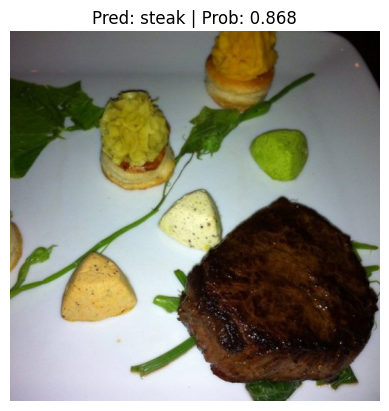

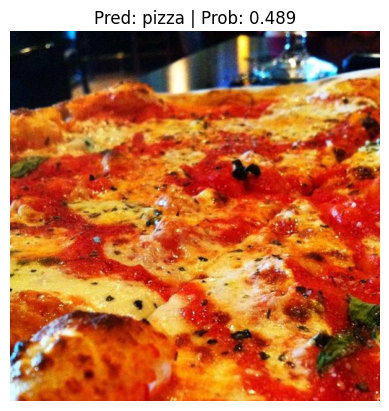

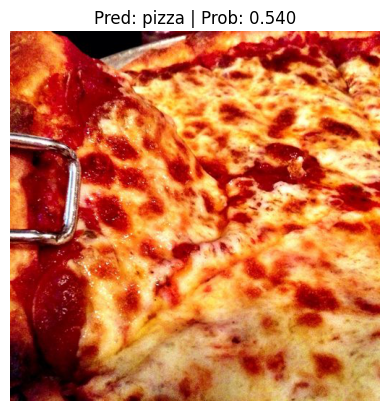

In [35]:
# Get a random list of image paths from the test set

import random

num_img_to_plot = 3
test_img_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_img_path_sample = random.sample(population=test_img_path_list, k=num_img_to_plot)

# Make prediction on and plot the images
for img_path in test_img_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=img_path, 
                        class_names=class_names, 
                        image_size=(224,224))



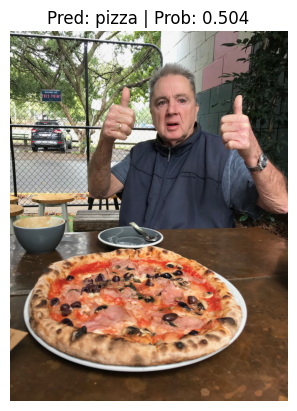

In [32]:
custom_img_path = data_path / '04-pizza-dad.jpeg'

pred_and_plot_image(model=model, image_path=custom_img_path, class_names=class_names, image_size=(224,224))



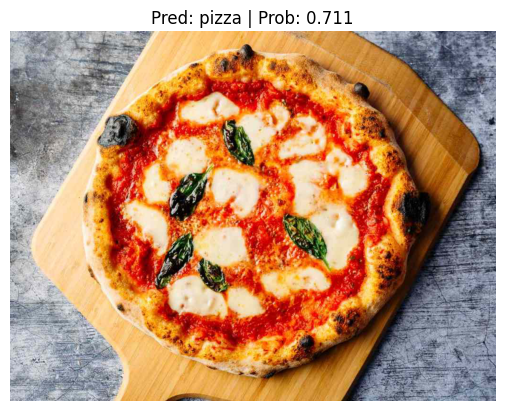

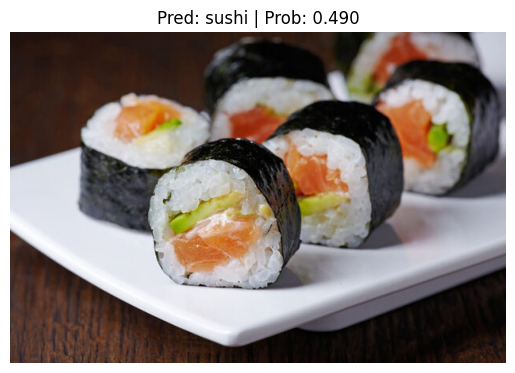

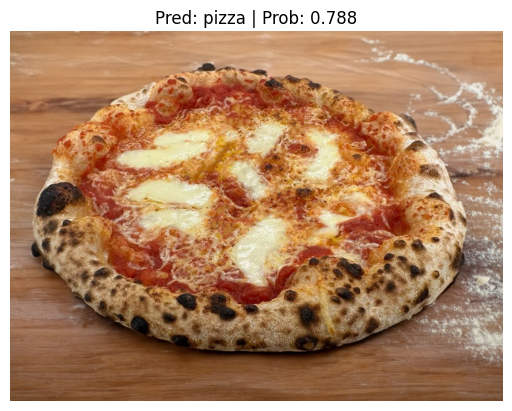

In [46]:

for x in list(Path(data_path).glob('*.jpg')):
    pred_and_plot_image(model=model, image_path=x, class_names=class_names, image_size=(224,224))

